Installing required packages

In [ ]:
!pip install wheel
!pip install pipwin
!pipwin install numpy
!pipwin install shapely
!pipwin install gdal
!pipwin install fiona
!pipwin install pyproj
!pipwin install six
!pipwin install rtree
!pipwin install geopandas
!pip install plotly
!pip install folium

Importing required packages for data accessing, analysis and visualization

In [1]:
import os
from google.cloud import bigquery
import pandas as pd
import numpy as np
from pylab import rcParams
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import folium
%matplotlib inline

Importing required packages needed for regression

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from random import randint
from scipy.stats import randint

Cred_Service.json has the access credentials for google cloud. Since the data is present on google cloud bigquery we had set an account and project. 
Dataset can be accesses using below link:
https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=chicago_taxi_trips

In [111]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="Cred_Service.json"
client = bigquery.Client(project='angular-argon-307703')

Getting the list of tables in the dataset. Here we have the whole data as one table which is 'taxi_trips'. This table is our source data.

In [112]:
data_ref = client.dataset("chicago_taxi_trips", project="bigquery-public-data")

# fetch the dataset
dataset = client.get_dataset(data_ref)
tables = list(client.list_tables(dataset))
for table in tables:  
    print(table.table_id)

taxi_trips


# Idenitifying Data issues

The next steps we will check if for each important feature if there are any data issues or missing values. We are considering data from 2014 t0 2020. 2013 data is exempted from analysis based on previous research work on this data and literature review.
2021 data was incomplete and continously changing during the course of this project, so it is removed from the analysis

In [113]:
# Checking if there are any records with missing trip_start_timestamp
trip_start_time = """ 
            SELECT extract(YEAR from trip_start_timestamp) year,count(*) as trip_start_date_nulls
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
            WHERE trip_start_timestamp is null
            AND extract(YEAR from trip_start_timestamp) between 2014 and 2020
            GROUP BY extract(YEAR from trip_start_timestamp)
        """
trip_start_time_job = client.query(trip_start_time)

trip_start_time_result = trip_start_time_job.to_dataframe()

# no records are found with missing time stamp
print(trip_start_time_result)

Empty DataFrame
Columns: [year, trip_start_date_nulls]
Index: []


In [114]:
# Checking if there are any records with missing trip_end_timestamp
trip_end_time = """ 
            SELECT extract(YEAR from trip_start_timestamp) year,count(*) as trip_end_date_nulls,
                   MIN(trip_seconds) min_trip_seconds,max(trip_seconds) as max_trip_seconds
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
            WHERE trip_end_timestamp is null
            AND extract(YEAR from trip_start_timestamp) between 2014 and 2020
            GROUP BY extract(YEAR from trip_start_timestamp)
        """

trip_end_time_job = client.query(trip_end_time)

trip_end_time_result = trip_end_time_job.to_dataframe()

# Trip_seconds is also missing so we time stamp can not be derived
print(trip_end_time_result)

   year  trip_end_date_nulls  min_trip_seconds  max_trip_seconds
0  2020                  574               NaN               NaN
1  2016                 2414               NaN               NaN
2  2018                  350               NaN               NaN
3  2017                  662               NaN               NaN
4  2019                  545               NaN               NaN
5  2015                 3591               NaN               NaN
6  2014                 5869               NaN               NaN


In [115]:
# Checking if there are any records where the trip start time is greater than trip end time

trip_time_issues = """ 
            SELECT trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
            WHERE trip_end_timestamp < trip_start_timestamp
            AND extract(YEAR from trip_start_timestamp) between 2014 and 2020
        """

trip_time_issues_job = client.query(trip_time_issues)

trip_time_issues_result = trip_time_issues_job.to_dataframe()

#53155 records have this issue

trip_time_issues_result.describe()
# No common data point is identified for this data

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,0.0,53175.000000,7166.000000,6957.000000,7166.000000,7166.000000,6962.000000,6962.000000
mean,NaN,0.533261,17.224812,18.498778,41.909567,-87.656289,41.911007,-87.657284
std,NaN,2.369732,16.500125,16.473484,0.039997,0.048794,0.044413,0.041978
min,NaN,0.000000,1.000000,1.000000,41.660136,-87.913625,41.689730,-87.913625
25%,NaN,0.000000,7.000000,7.000000,41.892042,-87.663518,41.885281,-87.670167
50%,NaN,0.000000,8.000000,8.000000,41.900221,-87.642808,41.905858,-87.649489
75%,NaN,0.000000,25.000000,28.000000,41.936310,-87.631864,41.942585,-87.631717
max,NaN,129.300000,77.000000,77.000000,42.009623,-87.551428,42.016046,-87.551428


In [116]:
# Checking for latitude and logitude missing records

latlong = """ 
            SELECT count(*) as pickup_latlong_nulls
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
            WHERE (pickup_latitude is null or pickup_longitude is null)
            AND extract(YEAR from trip_start_timestamp) between 2014 and 2020
        """
#safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)

latlong_job = client.query(latlong)

latlong_result = latlong_job.to_dataframe()

print(latlong_result)

   pickup_latlong_nulls
0              18441188


In [117]:
# Checking for distribution and existance of other useful features for latitude and logitude missing records

pickup_locations_null = """ 
            SELECT extract(YEAR from trip_start_timestamp) year, min(pickup_community_area) community_area_min, max(pickup_community_area) community_area_max
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
            WHERE (pickup_latitude is null or pickup_longitude is null)
            AND extract(YEAR from trip_start_timestamp) between 2014 and 2020
            GROUP BY extract(YEAR from trip_start_timestamp) 
        """

pickup_locations_null_job = client.query(pickup_locations_null)

pickup_locations_null_result = pickup_locations_null_job.to_dataframe()

# community area information is also missing for these records and the records are spanning across all years.
pickup_locations_null_result.describe()

,year,community_area_min,community_area_max
count,7.000000,0.0,0.0
mean,2017.000000,NaN,NaN
std,2.160247,NaN,NaN
min,2014.000000,NaN,NaN
25%,2015.500000,NaN,NaN
50%,2017.000000,NaN,NaN
75%,2018.500000,NaN,NaN
max,2020.000000,NaN,NaN


In [118]:
# Checking for trips that lasted more than 3 hours

time_diff = """ SELECT trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                          WHERE extract(YEAR from trip_start_timestamp) BETWEEN 2014 AND 2020
                            AND pickup_latitude is not null and dropoff_longitude is not null
                            AND TIMESTAMP_DIFF(trip_end_timestamp, trip_start_timestamp, MINUTE) > 180 """

time_diff_job = client.query(time_diff)

time_diff_result = time_diff_job.to_dataframe()

# 75% of the data has trips miles less than 9 which should not take morethan 30 minutes and 1567 miles trips is not possible with in chicago
time_diff_result.describe()

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,65715.000000,68583.000000,68594.000000,68482.000000,68616.000000,68616.000000,68616.000000,68616.000000
mean,35369.120094,8.290143,27.357626,26.852399,41.908161,-87.678536,41.911757,-87.680330
std,21240.547889,32.134684,23.966824,24.140677,0.054451,0.085224,0.058332,0.085247
min,10833.000000,0.000000,1.000000,1.000000,41.660136,-87.913625,41.660136,-87.913625
25%,16590.000000,0.360000,8.000000,8.000000,41.880994,-87.681356,41.880994,-87.695013
50%,29820.000000,1.730000,24.000000,22.000000,41.899507,-87.643965,41.899602,-87.649489
75%,49560.000000,8.935000,33.000000,33.000000,41.953582,-87.626659,41.965812,-87.628874
max,86400.000000,1567.200000,77.000000,77.000000,42.016011,-87.534903,42.016046,-87.534903


In [119]:
# Checking for trips that have trips total amount less than 3.25 (which is official minimum fare for any trip)

trip_total = """ SELECT count(*)
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                          WHERE extract(YEAR from trip_start_timestamp) BETWEEN 2014 AND 2020
                            AND pickup_latitude is not null and dropoff_longitude is not null
                            AND trip_total < 3.25 """

trip_total_job = client.query(trip_total)

trip_total_result = trip_total_job.to_dataframe()

#there are 185936 records with fare less than 3.25
trip_total_result.head()

,f0_
0,185936


In [120]:
# Checking distribution of trip miles. most of the records have less than 100 mile. Longest route which is from OHare to Hegewisch
# is only 50 miles considering double the 50 it should be more than 100 for trips with in chicago

trip_miles = """ SELECT round(trip_miles) trip_miles,count(*) trip_count
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                          WHERE extract(YEAR from trip_start_timestamp) BETWEEN 2014 AND 2020
                            AND pickup_latitude is not null and dropoff_longitude is not null
                GROUP BY trip_miles """

trip_miles_job = client.query(trip_miles)

trip_miles_result = trip_miles_job.to_dataframe()

trip_miles_result

,trip_miles,trip_count
0,325.0,16
1,155.0,129
2,470.0,96
3,252.0,24
4,111.0,274
...,...,...
1023,1234.0,1
1024,753.0,1
1025,607.0,1
1026,2350.0,1


Preparing the filter which will be used for all the queries in this notebook. 
We are going to fiter all the records which we identified as issues in the above section.
The conditions are as followed
1. Year of Pickup time should be between 2014 and 2020
2. Pickup latitude and logitudes should not be NULL
3. Trip end time stamp should not be NULL
4. Trip start time should be less than trip end time
5. Trip duration should be less than or equal to 180 minutes (3 hours)
6. Pickup and dropoff community areas should be present
7. Trip total amount should atleast be $3.25
8. Trip miles should be less than or equal to 100 miles

In [121]:
filters = """ 
            WHERE extract(YEAR from trip_start_timestamp) BETWEEN 2014 and 2020
            AND pickup_latitude is not null and pickup_longitude is not null
            AND trip_end_timestamp is not null
            AND trip_end_timestamp >= trip_start_timestamp
            AND TIMESTAMP_DIFF(trip_end_timestamp, trip_start_timestamp, MINUTE) < 180
            AND pickup_community_area is not null AND pickup_community_area > 0
            AND dropoff_community_area is not null AND dropoff_community_area > 0
            AND trip_total >= 3.25
            AND trip_miles <= 100
        """

Below query get the number of rides per day, we will see how the trend look like over the years

In [122]:
date_and_trips = """ 
            SELECT DATE(trip_start_timestamp) trip_date,
                   count(*) as trip_count
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
            """ + filters + """
            GROUP BY DATE(trip_start_timestamp)
        """

date_and_trips_job = client.query(date_and_trips)

date_and_trips_result = date_and_trips_job.to_dataframe()

date_and_trips_result.dtypes

trip_date     object
trip_count     int64
dtype: object

In [123]:
# Chanding the trip_date column to datetime and setting the trip_date as index
date_and_trips_result['trip_date']= pd.to_datetime(date_and_trips_result['trip_date'])
date_and_trips_result = date_and_trips_result.set_index('trip_date')

<AxesSubplot:xlabel='trip_date'>

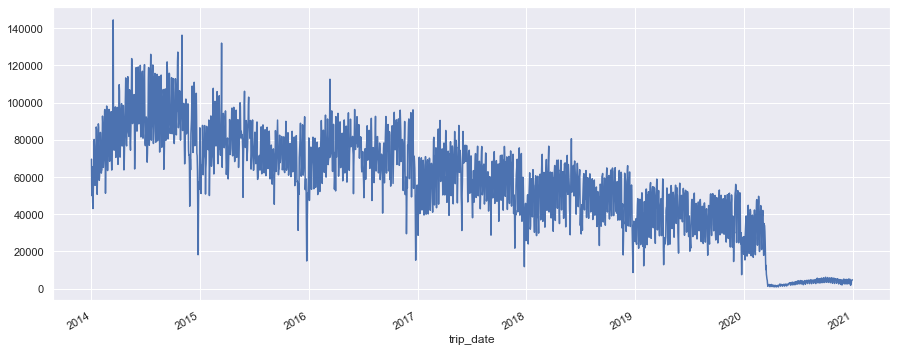

In [124]:
# The figure shows the trips per day over the years
fig, ax = plt.subplots(nrows=1, ncols=1)

date_and_trips_result.plot(figsize=(15, 6),ax=ax,legend=False)

Statistical Analysis, to understanding trend, sesonal behaviour

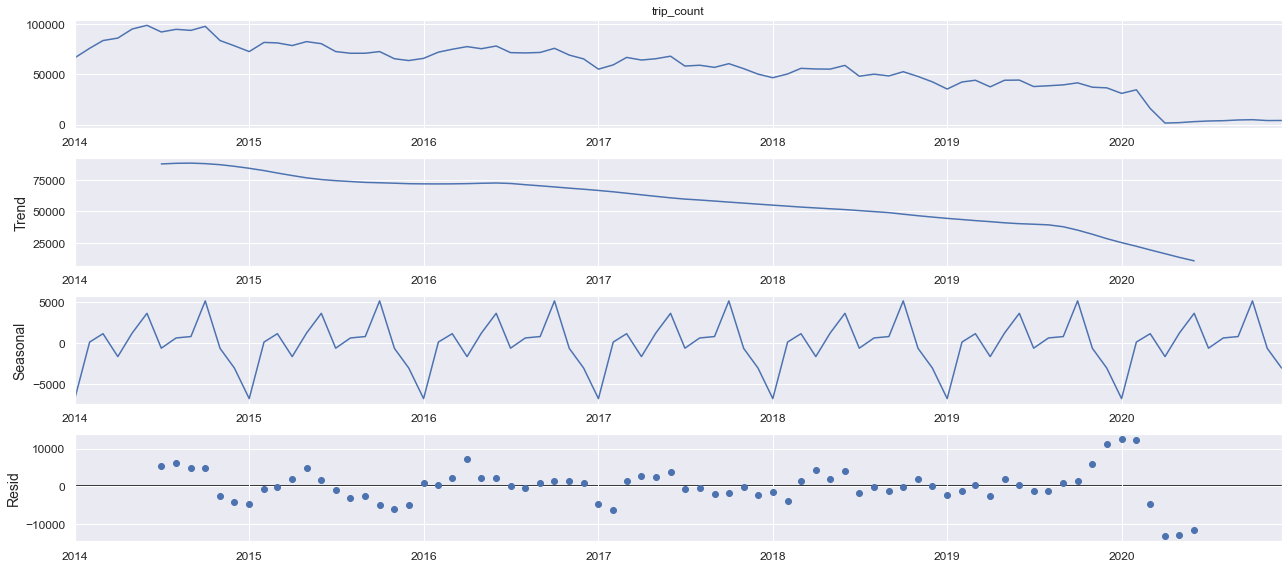

In [125]:
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

y = date_and_trips_result['trip_count'].resample('MS').mean()

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Query to get the number of rides per month for each year

In [126]:
monthly_rides_query = """ SELECT * FROM ( SELECT EXTRACT(MONTH from trip_start_timestamp) index_month,
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)) as month,
                                 EXTRACT(YEAR FROM trip_start_timestamp) year,
                                 count(*) trips
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        GROUP BY EXTRACT(MONTH from trip_start_timestamp),EXTRACT(YEAR FROM trip_start_timestamp),
                             FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp))) as a
                        ORDER BY index_month """

monthly_rides_query_job = client.query(monthly_rides_query)

monthly_rides_query_result = monthly_rides_query_job.to_dataframe()

monthly_rides_query_result.head()

,index_month,month,year,trips
0,1,January,2014,2065180
1,1,January,2018,1449269
2,1,January,2015,2256505
3,1,January,2020,965584
4,1,January,2019,1099897


Plotting the number of rides per month for each year. There is drastic decline in March and April of 2020.
October has high number of trips in most years

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



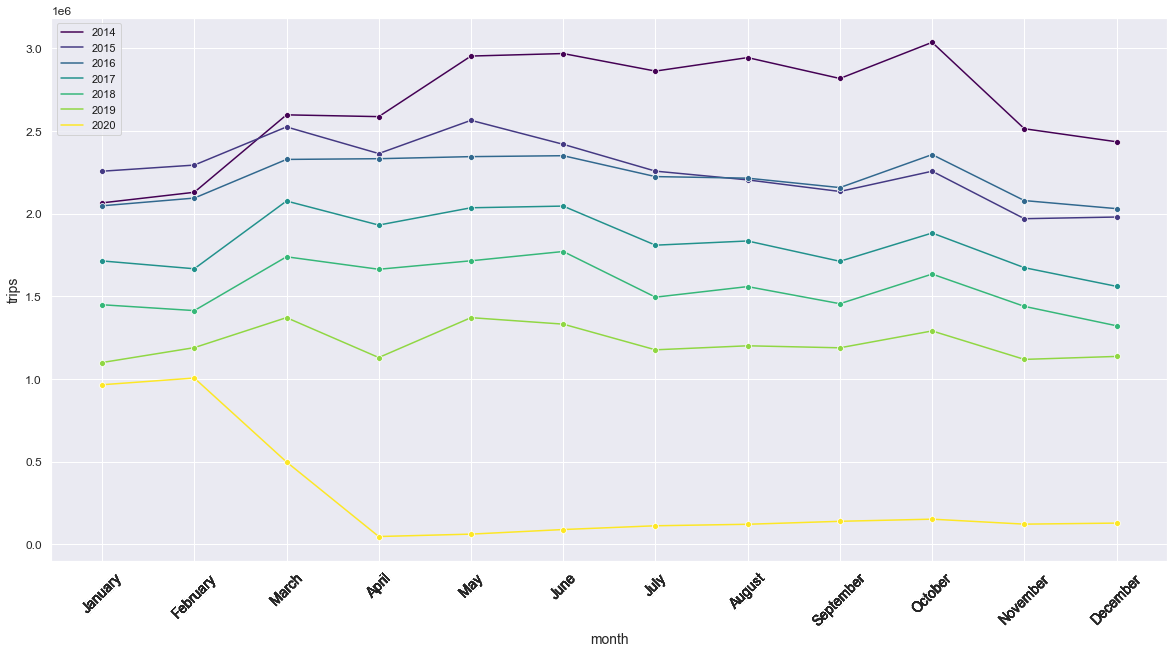

In [127]:
plt.figure(figsize=(20,10))

lp = sns.lineplot('month', 'trips', ci=None, marker='o', palette = "viridis",
             hue='year', data=monthly_rides_query_result)
lp.legend(loc='upper left')

plt.xticks(monthly_rides_query_result['month'], rotation=45,size=14)
plt.show()

Below query is to get the percentage of trips increased or decresed compared to previous month for year 2020.
Jan2020 percentage is the percentage chnge in number of trips compared to Dec2019
Feb2020 percentage is the percentage chnge in number of trips compared to Jan2020 and so on.

In [128]:
month_to_month = """ SELECT ((Jan2020-Dec2019)/Dec2019)*100 as Jan2020,
                            ((Feb2020-Jan2020)/Jan2020)*100 as Feb2020,
                            ((Mar2020-Feb2020)/Feb2020)*100 as Mar2020,
                            ((Apr2020-Mar2020)/Mar2020)*100 as Apr2020,
                            ((May2020-Apr2020)/Apr2020)*100 as May2020,
                            ((Jun2020-May2020)/May2020)*100 as Jun2020,
                            ((Jul2020-Jun2020)/Jun2020)*100 as Jul2020,
                            ((Aug2020-Jul2020)/Jul2020)*100 as Aug2020,
                            ((Sep2020-Aug2020)/Aug2020)*100 as Sep2020,
                            ((Oct2020-Sep2020)/Sep2020)*100 as Oct2020,
                            ((Nov2020-Oct2020)/Oct2020)*100 as Nov2020,
                            ((Dec2020-Nov2020)/Nov2020)*100 as Dec2020,
                    FROM (SELECT 
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=1 then 1 else 0 END) Jan2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=2 then 1 else 0 END) Feb2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=3 then 1 else 0 END) Mar2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=4 then 1 else 0 END) Apr2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=5 then 1 else 0 END) May2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=6 then 1 else 0 END) Jun2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=7 then 1 else 0 END) Jul2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=8 then 1 else 0 END) Aug2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=9 then 1 else 0 END) Sep2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=10 then 1 else 0 END) Oct2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=11 then 1 else 0 END) Nov2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=12 AND EXTRACT(Year from trip_start_timestamp)=2020 then 1 else 0 END) Dec2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=12 AND EXTRACT(Year from trip_start_timestamp)=2019 then 1 else 0 END) Dec2019
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                            AND (EXTRACT(YEAR from trip_start_timestamp)=2020 OR (EXTRACT(YEAR from trip_start_timestamp)=2019 AND EXTRACT(MONTH from trip_start_timestamp)=12) )
                        ) as a"""

month_to_month_job = client.query(month_to_month)

month_to_month_result = month_to_month_job.to_dataframe()

month_to_month_result.head()

,Jan2020,Feb2020,Mar2020,Apr2020,May2020,Jun2020,Jul2020,Aug2020,Sep2020,Oct2020,Nov2020,Dec2020
0,-15.064512,4.213823,-50.422053,-90.370002,30.131341,44.4089,25.207403,7.994444,14.71682,9.236383,-19.689631,5.165313


Bar plot with percentage changes

In [129]:
line = pd.Series(month_to_month_result.iloc[0,0:])
px.bar(line,x=line.index.values.tolist(),y=line,text=line,template='presentation',hover_name=line.index.values.tolist())

Query to get the avarage number of rides in a day per hour during weekdays and weekends for each year
DAYOFWEEK -1 is Sunday , 7 is Saturday

In [130]:
hourly_rides_query = """ SELECT ride_hour,weekday,ride_year,AVG(number_of_rides) as number_of_rides
                           FROM (SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                 EXTRACT(HOUR from trip_start_timestamp) ride_hour,
                                 CASE WHEN EXTRACT(DAYOFWEEK FROM trip_start_timestamp) IN (1,7) THEN 'Weekends' else 'Weekdays' END AS weekday,
                                 EXTRACT(YEAR from trip_start_timestamp) ride_year,
                                 COUNT(*) number_of_rides
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        GROUP BY EXTRACT(HOUR from trip_start_timestamp),
                                 EXTRACT(DATE from trip_start_timestamp),
                                 CASE WHEN EXTRACT(DAYOFWEEK FROM trip_start_timestamp) IN (1,7) THEN 'Weekends' else 'Weekdays' END,
                                 EXTRACT(YEAR from trip_start_timestamp) ) as a
                        GROUP BY ride_hour,weekday,ride_year
                        ORDER BY ride_hour """

hourly_rides_query_job = client.query(hourly_rides_query)

hourly_rides_query_result = hourly_rides_query_job.to_dataframe()

hourly_rides_query_result.head()

,ride_hour,weekday,ride_year,number_of_rides
0,0,Weekdays,2014,2305.429119
1,0,Weekdays,2016,1617.264368
2,0,Weekdays,2015,1880.022989
3,0,Weekends,2015,5160.009615
4,0,Weekends,2020,282.163462


Plotting the avarge trips per hours for both weekdays and weekends

Text(0.5, 0.98, 'Hourly Averages')

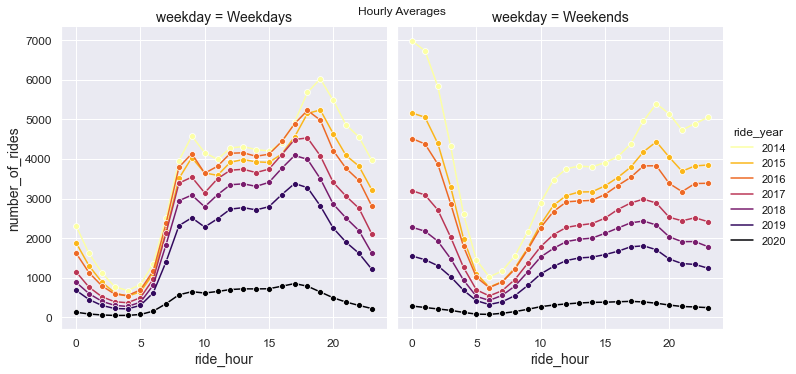

In [131]:
f = sns.relplot(x='ride_hour',y='number_of_rides',hue='ride_year',marker='o', palette = "inferno_r",col='weekday',kind='line',
            data=hourly_rides_query_result)
f.fig.suptitle("Hourly Averages")

Query to get the avarage number of rides for each day of the week and year

In [132]:
weekday_rides_query = """ SELECT weekday,ride_week,ride_year,AVG(number_of_rides) as number_of_rides 
                            FROM (SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                 EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS weekday,
                                 FORMAT_DATE('%A', trip_start_timestamp) ride_week,
                                 EXTRACT(YEAR from trip_start_timestamp) ride_year,
                                 COUNT(*) number_of_rides
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        GROUP BY EXTRACT(DATE from trip_start_timestamp),
                                 EXTRACT(DAYOFWEEK FROM trip_start_timestamp),
                                 FORMAT_DATE('%A', trip_start_timestamp),
                                 EXTRACT(YEAR from trip_start_timestamp) ) as a
                        GROUP BY weekday,ride_week,ride_year
                        ORDER BY weekday """

weekday_rides_query_job = client.query(weekday_rides_query)

weekday_rides_query_result = weekday_rides_query_job.to_dataframe()

weekday_rides_query_result.head()

,weekday,ride_week,ride_year,number_of_rides
0,1,Sunday,2019,26626.230769
1,1,Sunday,2014,83792.019231
2,1,Sunday,2018,36661.134615
3,1,Sunday,2015,67149.538462
4,1,Sunday,2017,45828.415094


Bar plot to show the number of rides per week
2020 has lowest number of ride for all the 7 days.

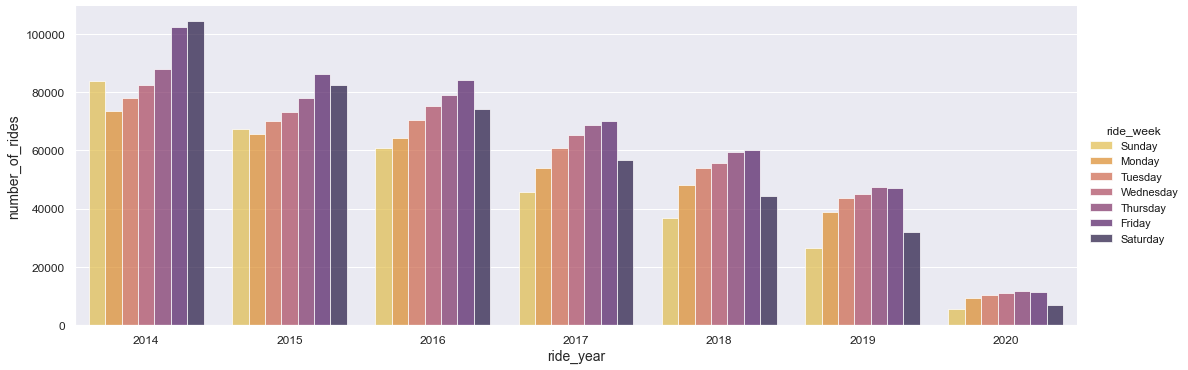

In [133]:
sns.catplot(x='ride_year',y='number_of_rides',hue='ride_week',
            data=weekday_rides_query_result,kind='bar',aspect=30/10,palette='inferno_r',alpha=0.7)

Below query is to get the percentage losses based on total amount for each company for the years 2019, 2020

In [134]:
company_rides_query = """ SELECT company,rides2019,rides2020,((rides2020-rides2019)/rides2019)*100 as loss_percent FROM (SELECT 
                                 company,
                                 SUM(CASE WHEN EXTRACT(YEAR from trip_start_timestamp)=2019 then trip_total else 0 END) rides2019,
                                 SUM(CASE WHEN EXTRACT(YEAR from trip_start_timestamp)=2020 then trip_total else 0 END) rides2020,
                                 SUM(trip_total) trips
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                            AND EXTRACT(YEAR from trip_start_timestamp) in (2019,2020)
                            AND REGEXP_CONTAINS(company, r'^[[:alpha:]]')
                        GROUP BY company) as a
                        WHERE rides2019 > 0
                        ORDER BY company """

company_rides_query_job = client.query(company_rides_query)

company_rides_query_result = company_rides_query_job.to_dataframe()

company_rides_query_result.head()

,company,rides2019,rides2020,loss_percent
0,American United,18656.47,0.00,-100.000000
1,American United Taxi Affiliation,37625.23,0.00,-100.000000
2,Blue Diamond,960148.57,12270.33,-98.722038
3,Blue Ribbon Taxi Association Inc.,10266022.78,1900944.71,-81.483143
4,Checker Taxi,13549.04,0.00,-100.000000


Bar plot showing the percentage gain or loss for each company

In [135]:
fig = px.bar(company_rides_query_result,y='loss_percent',x='company')
fig.show()

Query to get the avarage tip amount for each day and plotting

<AxesSubplot:xlabel='trip_date'>

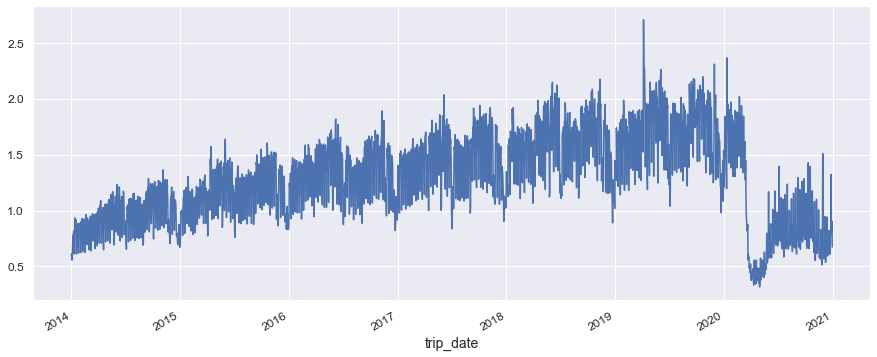

In [136]:
tips_behaviour = """ 
            SELECT DATE(trip_start_timestamp) trip_date,
                   avg(tips) as tip_amount
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
            """ + filters + """
            GROUP BY DATE(trip_start_timestamp)
        """

tips_behaviour_job = client.query(tips_behaviour)

tips_behaviour_result = tips_behaviour_job.to_dataframe()

# Changing trip_date from string to datetime 
tips_behaviour_result['trip_date']= pd.to_datetime(tips_behaviour_result['trip_date'])

# Setting trip_date as index for plotting
tips_behaviour_result = tips_behaviour_result.set_index('trip_date')

fig, ax = plt.subplots(nrows=1, ncols=1)

tips_behaviour_result.plot(figsize=(15, 6),ax=ax,legend=False)


Below query gets the number of unique active taxis that have atleast one trip for each month of 2020

In [137]:
active_taxis = """ SELECT index_month,month,active_taxis
                     FROM (SELECT EXTRACT(MONTH from trip_start_timestamp) index_month,
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)) as month,
                                 COUNT(DISTINCT taxi_id) active_taxis
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                           AND EXTRACT(YEAR from trip_start_timestamp) = 2020
                        GROUP BY EXTRACT(MONTH from trip_start_timestamp),
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp))) a
                        ORDER BY index_month """

active_taxis_job = client.query(active_taxis)

active_taxis_result = active_taxis_job.to_dataframe()

active_taxis_result.head()

,index_month,month,active_taxis
0,1,January,3813
1,2,February,3866
2,3,March,3829
3,4,April,635
4,5,May,450


Plotting the number of active taxis for each month of 2020

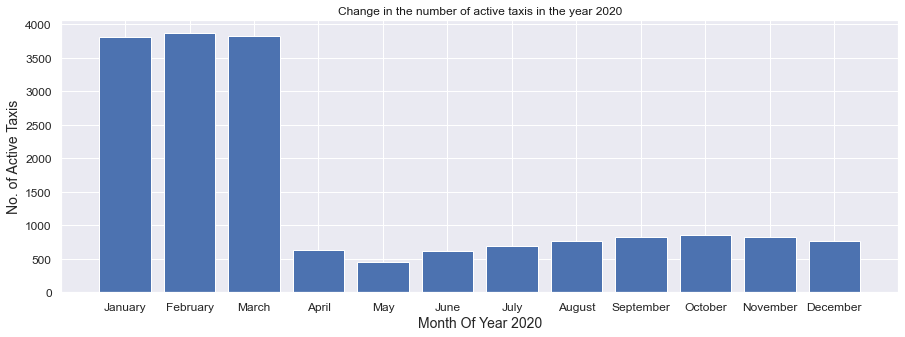

In [138]:
fig = plt.figure(figsize = (15, 5))

plt.bar(active_taxis_result['month'],active_taxis_result['active_taxis'])

plt.xlabel("Month Of Year 2020")
plt.ylabel("No. of Active Taxis")
plt.title("Change in the number of active taxis in the year 2020")
plt.show()

The below query has two parts
1. First part of the query get the avearge travel times (In minutes) over the years for each day
2. Second part of the query get the avearge travel distances (miles) over the years for each day

In [139]:
avg_travel_times = """ SELECT month_index,date,year,month,weekday,measurement_type,measurement_value
                     FROM (SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                 EXTRACT(YEAR from trip_start_timestamp) year,
                                 EXTRACT(MONTH from trip_start_timestamp) month_index,
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)) as month,
                                 CASE WHEN EXTRACT(DAYOFWEEK FROM trip_start_timestamp) IN (1,7) THEN 'Weekends' else 'Weekdays' END AS weekday,
                                 'Trip Time' as measurement_type,
                                 AVG(trip_seconds/60) measurement_value
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        GROUP BY EXTRACT(DATE from trip_start_timestamp),
                                EXTRACT(YEAR from trip_start_timestamp),
                                EXTRACT(MONTH from trip_start_timestamp),
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)),
                                 CASE WHEN EXTRACT(DAYOFWEEK FROM trip_start_timestamp) IN (1,7) THEN 'Weekends' else 'Weekdays' END
                            UNION ALL
                            SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                 EXTRACT(YEAR from trip_start_timestamp) year,
                                 EXTRACT(MONTH from trip_start_timestamp) month_index,
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)) as month,
                                 CASE WHEN EXTRACT(DAYOFWEEK FROM trip_start_timestamp) IN (1,7) THEN 'Weekends' else 'Weekdays' END AS weekday,
                                 'Trip Distance' as measurement_type,
                                 AVG(trip_miles) measurement_value
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        GROUP BY EXTRACT(DATE from trip_start_timestamp),
                                EXTRACT(YEAR from trip_start_timestamp),
                                EXTRACT(MONTH from trip_start_timestamp),
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)),
                                 CASE WHEN EXTRACT(DAYOFWEEK FROM trip_start_timestamp) IN (1,7) THEN 'Weekends' else 'Weekdays' END) a
                        ORDER BY month_index """

avg_travel_times_job = client.query(avg_travel_times)

avg_travel_times_result = avg_travel_times_job.to_dataframe()

# taking the mean for each year, month, weekday and measurememt type (types are travel time and travel distance)
travel_times = avg_travel_times_result.groupby(['month_index','year','month','weekday','measurement_type'], as_index=False)['measurement_value'].mean()
travel_times.columns=['MONTH_INDEX','YEAR','MONTH','WEEKDAY','MEASUREMENT_TYPE','MEASUREMENT_VALUE']

# Seperating the results for travel times and travel distances
trip_distance =  travel_times.loc[travel_times['MEASUREMENT_TYPE'] == 'Trip Distance']
trip_travel_times =  travel_times.loc[travel_times['MEASUREMENT_TYPE'] == 'Trip Time']

trip_distance.head()

,MONTH_INDEX,YEAR,MONTH,WEEKDAY,MEASUREMENT_TYPE,MEASUREMENT_VALUE
0,1,2014,January,Weekdays,Trip Distance,2.061655
2,1,2014,January,Weekends,Trip Distance,1.990869
4,1,2015,January,Weekdays,Trip Distance,2.772031
6,1,2015,January,Weekends,Trip Distance,2.690116
8,1,2016,January,Weekdays,Trip Distance,2.885560


Plotting both travel time and distances

Text(0.5, 0.98, 'Travel Times')

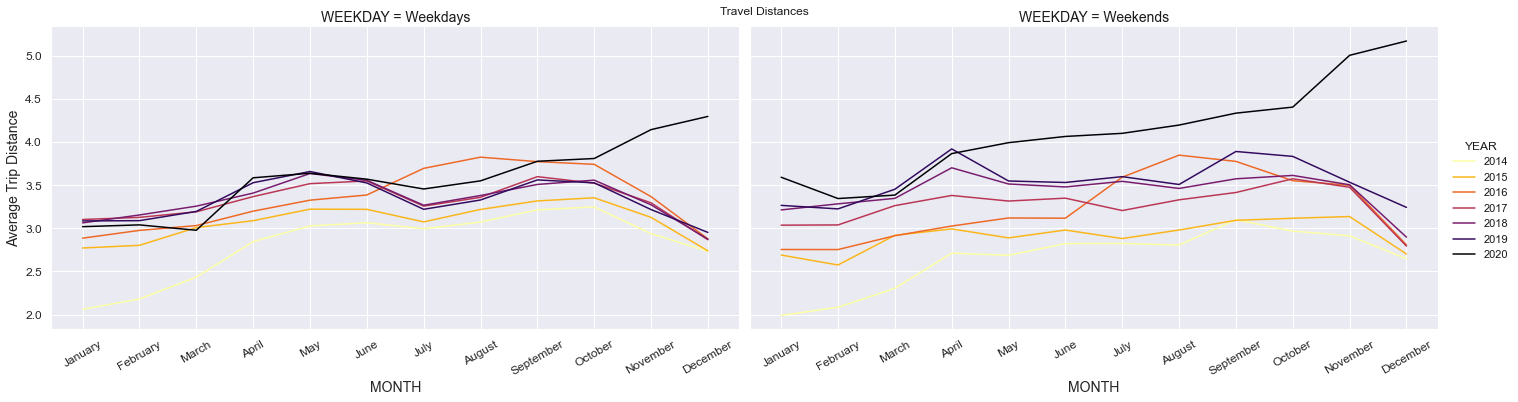

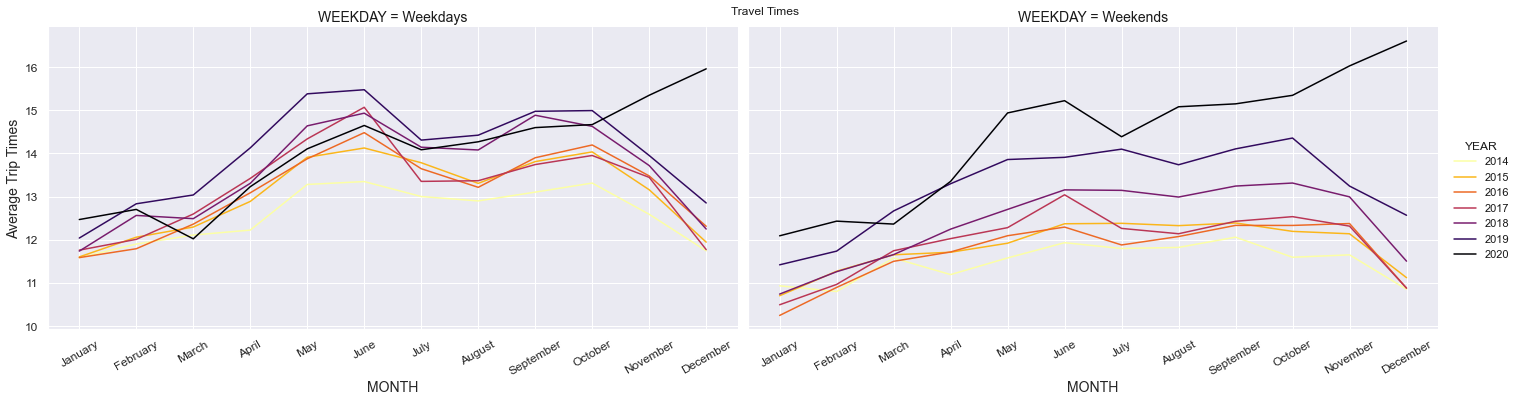

In [140]:
td = sns.relplot(x='MONTH',y='MEASUREMENT_VALUE',hue='YEAR',col='WEEKDAY',palette = "inferno_r",kind='line',
            data=trip_distance,aspect=10/5)

td.set_xticklabels(rotation=30)
td.set_ylabels('Average Trip Distance')
td.fig.suptitle("Travel Distances")

tt = sns.relplot(x='MONTH',y='MEASUREMENT_VALUE',hue='YEAR',col='WEEKDAY',palette = "inferno_r",kind='line',
            data=trip_travel_times,aspect=10/5)

tt.set_xticklabels(rotation=30)
tt.set_ylabels('Average Trip Times')
tt.fig.suptitle("Travel Times")

Below query gets the avarge wait time of the taxis over the years starting from 2018.
Wait time is time in between dropoff and next pickup

In [141]:
wait_times = """ SELECT * FROM 
                          (SELECT extract(date from date) trip_date,avg(wait_time) wait_time 
                             FROM (
                                   SELECT taxi_id,date,date_l,TIMESTAMP_DIFF(date, date_l, MINUTE) wait_time
                                    FROM 
                                        (SELECT taxi_id,trip_start_timestamp date,
                                                lag(trip_start_timestamp) 
                                                OVER (PARTITION BY taxi_id ORDER BY trip_start_timestamp) date_l
                                           FROM bigquery-public-data.chicago_taxi_trips.taxi_trips
                                           """ + filters + """
                                            AND  EXTRACT(year from trip_start_timestamp)>2018))
                                    GROUP BY extract(date from date))
                        WHERE wait_time<=1440
                    ORDER BY wait_time """

wait_times_job = client.query(wait_times)

wait_times_result = wait_times_job.to_dataframe()

# changing trip_date to datetime and setting it as index for plotting
wait_times_result['trip_date']= pd.to_datetime(wait_times_result['trip_date'])
wait_times_result = wait_times_result.set_index('trip_date')

wait_times_result.head()

,wait_time
trip_date,
2019-01-01,69.486318
2019-03-16,104.784631
2019-12-06,107.698275
2019-05-17,109.563845
2019-12-12,111.106504


Plotting avarage wait time

<AxesSubplot:xlabel='trip_date'>

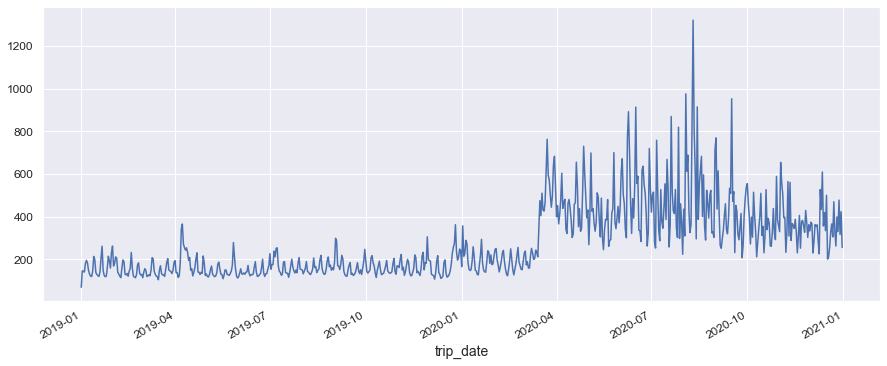

In [142]:
fig, ax = plt.subplots(nrows=1, ncols=1)

wait_times_result.plot(figsize=(15, 6),ax=ax,legend=False)

Below query gets the avarge trips per taxi in a day over the years starting from 2018

In [143]:
trips_per_taxi = """ SELECT trip_date,AVG(trips) as trips
                       FROM 
                           (SELECT taxi_id,EXTRACT(DATE FROM trip_start_timestamp) trip_date,count(*) trips
                              FROM bigquery-public-data.chicago_taxi_trips.taxi_trips
                              """ + filters + """
                               AND  EXTRACT(year from trip_start_timestamp)>2018
                          GROUP BY taxi_id,EXTRACT(DATE FROM trip_start_timestamp))
                    GROUP BY trip_date """

trips_per_taxi_job = client.query(trips_per_taxi)

trips_per_taxi_result = trips_per_taxi_job.to_dataframe()

# changing trip_date to datetime and setting it as index for plotting
trips_per_taxi_result['trip_date']= pd.to_datetime(trips_per_taxi_result['trip_date'])
trips_per_taxi_result = trips_per_taxi_result.set_index('trip_date')

trips_per_taxi_result.head()

,trips
trip_date,
2020-02-28,12.853587
2020-02-04,11.556338
2020-02-15,9.650496
2020-02-25,11.660327
2020-02-23,7.505834


Plotting avrage trips per taxi in a day

<AxesSubplot:xlabel='trip_date'>

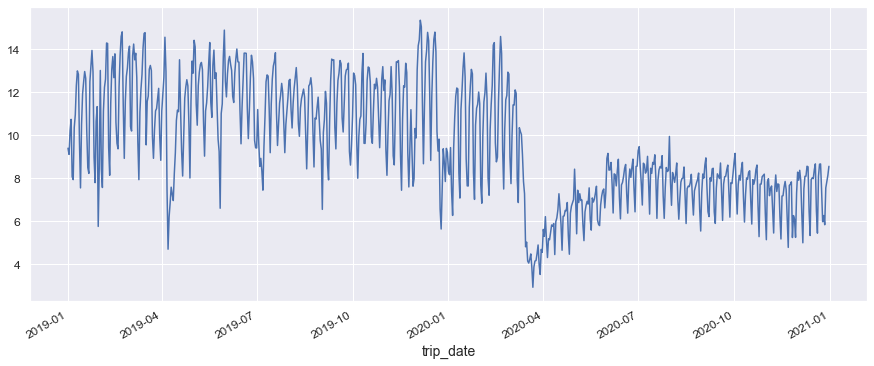

In [144]:
fig, ax = plt.subplots(nrows=1, ncols=1)

trips_per_taxi_result.plot(figsize=(15, 6),ax=ax,legend=False)

Reading shape file for the plotting using GeoPandas
The shape file is downloaded from below website
https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6

In [2]:
chicago_map = gpd.read_file("BoundariesCommunityAreas/geo_export_548d824e-98de-4d9c-9ba4-50a151c3f993.shp")

pickup_area_query - This query gets the number of trips for each day and each pickup community area for the years from 2014 to 2020
dropoff_area_query - This query gets the number of trips for each day and each dropoff community area for the years from 2014 to 2020

period column is calcaulated as below:
if the trip happend before March- 2020 then it is considered PRE-COVID
if the trip happend after March- 2020 then it is considered COVID  

In [146]:
pickup_area_query = """ SELECT * FROM (SELECT 
                                 pickup_community_area as area_num_1,
                                 DATE(trip_start_timestamp) trip_date,
                                 EXTRACT(YEAR from trip_start_timestamp) year,
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END as period,
                                 COUNT(*) trips
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        AND pickup_community_area > 0
                        GROUP BY pickup_community_area,
                        DATE(trip_start_timestamp),
                                 EXTRACT(YEAR from trip_start_timestamp),
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END ) as a
                        ORDER BY area_num_1 """

pickup_area_query_job = client.query(pickup_area_query)

pickup_area_query_result = pickup_area_query_job.to_dataframe()

# Changing the data types of area_num_1 column in both pickup_area_query_result and chicago_map so that we can join them together
pickup_area_query_result['area_num_1'] = pickup_area_query_result['area_num_1'].astype(int)
chicago_map['area_num_1'] = chicago_map['area_num_1'].astype(int)

# Taking the mean for the number of trips basing pickup area and period
pickup_area_query_result = pickup_area_query_result.groupby(['area_num_1','period'], as_index=False)['trips'].mean()
pickup_area_query_result.columns=['area_num_1','period','trips']
pickup_area_query_result.head()

# Joining pickup_area and chicago_map based on area_num_1 (pickup community area)
pickup_area_density_result = chicago_map.merge(pickup_area_query_result, on="area_num_1", how = 'inner')

# Repeating above steps for dropoff community area
dropoff_area_query = """ SELECT * FROM (SELECT 
                                 dropoff_community_area as area_num_1,
                                 DATE(trip_start_timestamp) trip_date,
                                 EXTRACT(YEAR from trip_start_timestamp) year,
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END as period,
                                 COUNT(*) trips
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        AND dropoff_community_area > 0
                        GROUP BY dropoff_community_area,
                                 DATE(trip_start_timestamp),
                                 EXTRACT(YEAR from trip_start_timestamp),
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END ) as a
                        ORDER BY area_num_1 """

dropoff_area_query_job = client.query(dropoff_area_query)

dropoff_area_query_result = dropoff_area_query_job.to_dataframe()

# Changing the data types of area_num_1 column dropoff_area_query_result to join with chicago_map
dropoff_area_query_result['area_num_1'] = dropoff_area_query_result['area_num_1'].astype(int)

# Taking the mean for the number of trips basing dropoff area and period
dropoff_area_query_result = dropoff_area_query_result.groupby(['area_num_1','period'], as_index=False)['trips'].mean()
dropoff_area_query_result.columns=['area_num_1','period','trips']
dropoff_area_query_result.head()

# Joining dropoff_area_density_result and chicago_map based on area_num_1 (dropoff community area)
dropoff_area_density_result = chicago_map.merge(dropoff_area_query_result, on="area_num_1", how = 'inner')

dropoff_area_density_result.head()

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,period,trips
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((-87.60914 41.84469, -87.60915 41.844...",COVID,65.225490
1,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((-87.60914 41.84469, -87.60915 41.844...",PRE-COVID,174.121279
2,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((-87.59215 41.81693, -87.59231 41.816...",COVID,21.418301
3,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((-87.59215 41.81693, -87.59231 41.816...",PRE-COVID,21.322523
4,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.62880 41.80189, -87.62879 41.801...",COVID,12.088235


Text(0.5, 1.0, 'Average Dropoffs Per Day During COVID')

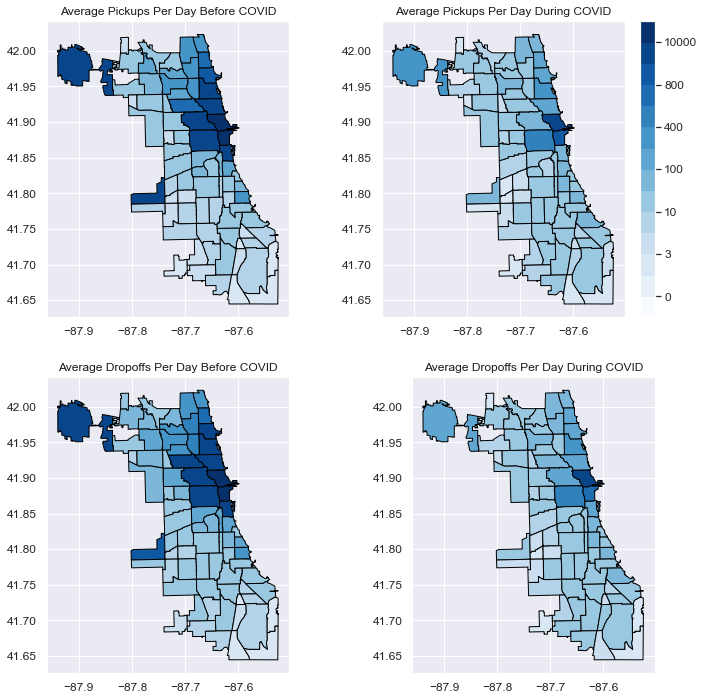

In [147]:
# 4 axis to plot pickup and dropoff densities before and during COVID period
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,12))

# Color map is set to Blues , a sequential color map
cmap = mpl.cm.Blues
# Setting the bounds to be consistent for all 4 axis
bounds = [-1, 0, 1, 3, 5, 10, 50, 100, 200, 400, 600, 800, 1000, 10000, 15000]
# Mapping bounds and colors to be used for legend
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Seperate the pickup data from the result set based on period
pickup_precovid = pickup_area_density_result.loc[pickup_area_density_result['period'] == 'PRE-COVID']
pickup_covid = pickup_area_density_result.loc[pickup_area_density_result['period'] == 'COVID']

# Pickup density for precovid plot
ax1 = pickup_precovid.plot(column="trips",legend=False,
                        edgecolor='black',ax=ax1, cmap=cmap,norm=norm
                      )

ax1.set_title('Average Pickups Per Day Before COVID')

# Pickup density during covid plot
ax2 = pickup_covid.plot(column="trips",legend=True,
                        edgecolor='black',ax=ax2, cmap=cmap,norm=norm
                      )

ax2.set_title('Average Pickups Per Day During COVID')

# Seperate the dropoff data from the result set based on period
dropoff_precovid = dropoff_area_density_result.loc[dropoff_area_density_result['period'] == 'PRE-COVID']
dropoff_covid = dropoff_area_density_result.loc[dropoff_area_density_result['period'] == 'COVID']

# Dropoff density for precovid plot
ax3 = dropoff_precovid.plot(column="trips",legend=False,
                        edgecolor='black',ax=ax3, cmap=cmap,norm=norm
                      )

ax3.set_title('Average Dropoffs Per Day Before COVID')

# Dropoff density during covid plot
ax4 = dropoff_covid.plot(column="trips",legend=False,
                        edgecolor='black',ax=ax4, cmap=cmap,norm=norm
                      )

ax4.set_title('Average Dropoffs Per Day During COVID')

Below query get the avarage number of trips for the Far Southeast side of the city 
where the density seems slightly increased for pickups

In [148]:
pickup_observations = """ SELECT year,Area_Name,Region,AVG(trips) trips  
                            FROM (SELECT 
                                 EXTRACT(date from trip_start_timestamp) as index,
                                 case when pickup_community_area = 50 then 'Pullman'
                                      when pickup_community_area = 52 then 'East Side'
                                      when pickup_community_area = 54 then 'Riverdale'
                                      when pickup_community_area = 55 then 'Hegewisch'
                                      when pickup_community_area = 38 then 'Grand Boulevard'
                                      when pickup_community_area = 69 then 'Greater Grand Crossing'
                                      else 'South Shore' end as Area_Name,
                                      CASE WHEN pickup_community_area in (43,38,69) THEN 'Increased'
                                           WHEN pickup_community_area in (52,55,54,50) THEN 'Increased'
                                      else 'HighDensity' END as Region,
                                 EXTRACT(YEAR from trip_start_timestamp) year,
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)) as month,
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END as period,
                                 COUNT(*) trips
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        AND pickup_community_area > 0
                        AND pickup_community_area in (52,55,54,50,43,38,69)
                        GROUP BY EXTRACT(date from trip_start_timestamp),
                                  pickup_community_area,
                                 EXTRACT(YEAR from trip_start_timestamp),
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)),
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END ) as a
                        GROUP BY year,Area_Name,Region"""

pickup_observations_job = client.query(pickup_observations)

pickup_observations_result = pickup_observations_job.to_dataframe()

pickup_observations_result.head()

,year,Area_Name,Region,trips
0,2015,Greater Grand Crossing,Increased,10.775342
1,2014,Grand Boulevard,Increased,25.983562
2,2014,Hegewisch,Increased,1.327731
3,2014,South Shore,Increased,28.290411
4,2014,Greater Grand Crossing,Increased,11.936986


Plotting avarage number of trips per day for Far Southeast side areas

<AxesSubplot:xlabel='Area_Name', ylabel='trips'>

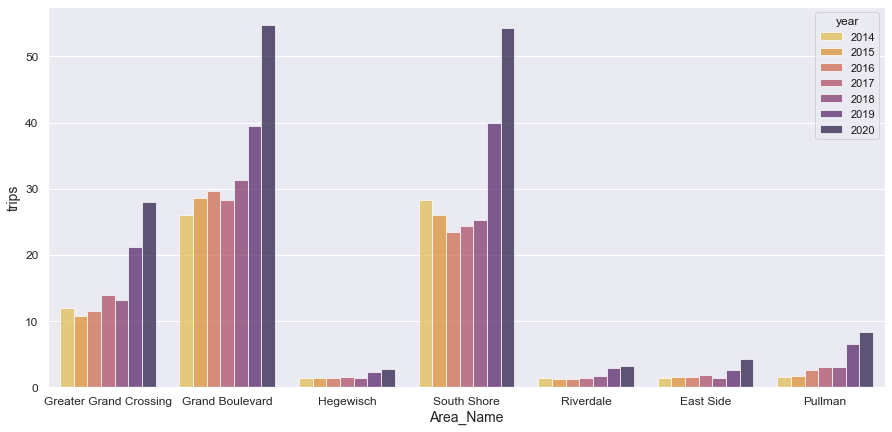

In [149]:
fig = plt.figure(figsize = (15, 7))

sns.barplot(x='Area_Name',y='trips',hue='year',
                palette="inferno_r",
            data=pickup_observations_result,alpha=0.7)

Below query get the avarage number of trips for the Pullman and Southshore area from Far Southeast side of the city where the density seems slightly increased for dropoff

In [150]:
dropoff_observations = """ SELECT * FROM (SELECT 
                                 EXTRACT(MONTH from trip_start_timestamp) as index,
                                 case when dropoff_community_area = 50 then 'Pullman'
                                      else 'South Shore' end as Area_Name,
                                      CASE WHEN dropoff_community_area in (43,38,69) THEN 'South'
                                      else 'East' END as Region,
                                 EXTRACT(YEAR from trip_start_timestamp) year,
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)) as month,
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END as period,
                                 COUNT(*) trips
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        AND dropoff_community_area > 0
                        AND dropoff_community_area in (50,43)
                        GROUP BY EXTRACT(MONTH from trip_start_timestamp),
                                  dropoff_community_area,
                                 EXTRACT(YEAR from trip_start_timestamp),
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)),
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END ) as a
                        ORDER BY index """

dropoff_observations_job = client.query(dropoff_observations)

dropoff_observations_result = dropoff_observations_job.to_dataframe()


dropoff_observations_east = dropoff_observations_result.loc[dropoff_observations_result['Region'] == 'East']
dropoff_observations_south = dropoff_observations_result.loc[dropoff_observations_result['Region'] == 'South']

Plotting the avarage number of dropoff for Pullman and South Shore areas

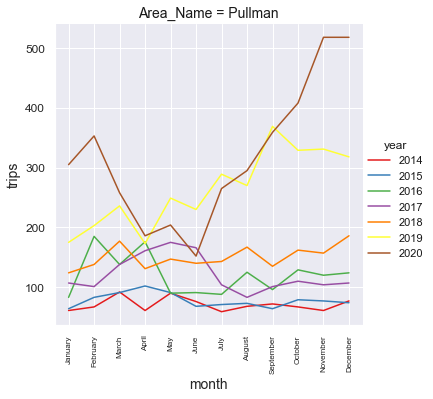

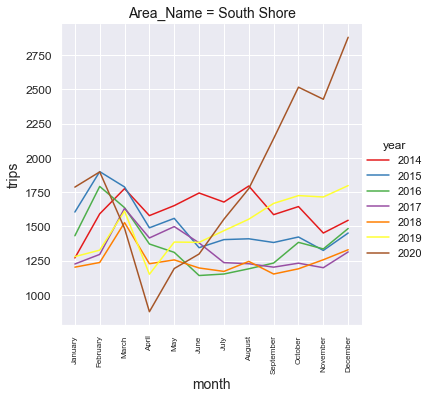

In [151]:
g = sns.relplot(x='month',y='trips',hue='year',col='Area_Name',kind='line',palette="Set1",
            data=dropoff_observations_east)
g.set_xticklabels(rotation=90,size=8)

h = sns.relplot(x='month',y='trips',hue='year',palette="Set1",kind='line',col='Area_Name',
            data=dropoff_observations_south)
h.set_xticklabels(rotation=90,size=8)

In earlier sections we have seen densities for community areas.
In this section we will see the popular pickup and dropoff locations based on lat long columns
The below queries gets the the number of trips for each latitude and longitude combination and then we are filtering top 20 records based on trip count.

In [152]:
# query to get the number of pickups for each latitude and longitude combination
pickup_locations = """ SELECT EXTRACT(YEAR from trip_start_timestamp) ride_year,
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 4 THEN 'PRE-COVID' ELSE 'COVID' END as period,
                                  pickup_latitude,
                                  pickup_longitude,
                                  count(*) trip_count
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                       """ + filters + """
                           AND extract(DATE from trip_start_timestamp) between PARSE_DATE('%m/%d/%Y', '07/01/2019') and PARSE_DATE('%m/%d/%Y', '12/31/2020')
                        GROUP BY EXTRACT(YEAR from trip_start_timestamp),
                        CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 4 THEN 'PRE-COVID' ELSE 'COVID' END,
                        pickup_latitude,pickup_longitude """

pickup_locations_job = client.query(pickup_locations)

pickup_locations_result = pickup_locations_job.to_dataframe()

#Sepearating data for precovid and covid
pickup_before = pickup_locations_result.loc[pickup_locations_result['period'] == 'PRE-COVID']
pickup_after = pickup_locations_result.loc[pickup_locations_result['period'] == 'COVID']

#Sorting the results based on number of trips in descending order
pickup_before=pickup_before.sort_values(by=['trip_count'],ascending=False)
pickup_after=pickup_after.sort_values(by=['trip_count'],ascending=False)

#Filtering TOP 20 records
pickup_before_top20 = pickup_before.head(20)
pickup_after_top20 = pickup_after.head(20)

# query to get the number of dropoffs for each latitude and longitude combination
dropoff_locations = """ SELECT EXTRACT(YEAR from trip_start_timestamp) ride_year,
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 4 THEN 'PRE-COVID' ELSE 'COVID' END as period,
                                  dropoff_latitude,
                                  dropoff_longitude,
                                  count(*) trip_count
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                       """ + filters + """
                           AND extract(DATE from trip_start_timestamp) between PARSE_DATE('%m/%d/%Y', '07/01/2019') and PARSE_DATE('%m/%d/%Y', '12/31/2020')
                        GROUP BY EXTRACT(YEAR from trip_start_timestamp),
                        CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 4 THEN 'PRE-COVID' ELSE 'COVID' END,
                        dropoff_latitude,dropoff_longitude """

dropoff_locations_job = client.query(dropoff_locations)

dropoff_locations_result = dropoff_locations_job.to_dataframe()

#Sepearating data for precovid and covid
dropoff_before = dropoff_locations_result.loc[dropoff_locations_result['period'] == 'PRE-COVID']
dropoff_after = dropoff_locations_result.loc[dropoff_locations_result['period'] == 'COVID']

#Sorting the results based on number of trips in descending order
dropoff_before=dropoff_before.sort_values(by=['trip_count'],ascending=False)
dropoff_after=dropoff_after.sort_values(by=['trip_count'],ascending=False)

#Filtering TOP 20 records
dropoff_before_top20 = dropoff_before.head(20)
dropoff_after_top20 = dropoff_after.head(20)

Plotting TOP 20 pickup and dropoff locations on chicago map
Green represents pickup locations
Red represents dropoff locations

Text(429.86136363636354, 0.5, 'Latitude')

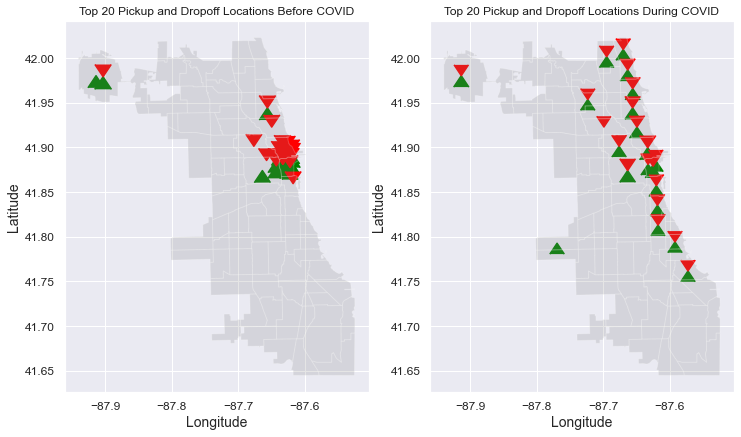

In [153]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

#Setting the size of scatter based on trip count
sizes_pre = np.log10(pickup_before_top20['trip_count'])*50
sizes_post = np.log10(pickup_after_top20['trip_count'])*50

#Plotting top 20 pickup locations before covid
ax1 = pickup_before_top20.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude",
                       title="Top 20 Pickup and Dropoff Locations Before COVID",
                       color="green", s=sizes_pre,
                       ax=ax1, marker = 6
                      )

#Plotting top 20 dropoff locations before covid
ax1 = dropoff_before_top20.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude",
                       title="Top 20 Pickup and Dropoff Locations Before COVID",
                       color="red", s=sizes_pre,
                       ax=ax1, marker = 7
                      )

#Plotting Chicago map
chicago_map.plot(color='grey', edgecolor='white',ax=ax1, alpha = 0.2)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

#Plotting top 20 pickup locations during covid
ax2 = pickup_after_top20.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude",
                       title="Top 20 For Pickup and Dropoff Locations During COVID",
                      color="green", s=sizes_post,
                       ax=ax2, marker = 6
                      )

#Plotting top 20 dropoff locations during covid
ax2 = dropoff_after_top20.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude",
                       title="Top 20 Pickup and Dropoff Locations During COVID",
                       color="red", s=sizes_post,
                       ax=ax2, marker = 7
                      )

#Plotting Chicago map
chicago_map.plot(color='grey', edgecolor='white',ax=ax2, alpha = 0.2)

ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

In the below section we are trying to get the locations where the average number of pickups is doubled during the COVID compared to earlier

In [154]:
#Average number of pickups per day before COVID for each location
before_pk = """ SELECT pickup_latitude,
                    pickup_longitude,
                    ROUND(avg(trip_count)) trip_count
                FROM (SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                  'PRE-COVID'as period,
                                  pickup_latitude,
                                  pickup_longitude,
                                  count(*) trip_count
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                       """ + filters + """
                           AND extract(DATE from trip_start_timestamp) between PARSE_DATE('%m/%d/%Y', '01/01/2014') and PARSE_DATE('%m/%d/%Y', '04/30/2020')
                        GROUP BY EXTRACT(DATE from trip_start_timestamp),
                        pickup_latitude,pickup_longitude) aa
                GROUP BY pickup_latitude,
                    pickup_longitude"""

#Average number of pickups per day during COVID for each location
after_pk = """ SELECT pickup_latitude,
                    pickup_longitude,
                    ROUND(avg(trip_count)) trip_count
                FROM (SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                  'COVID'as period,
                                  pickup_latitude,
                                  pickup_longitude,
                                  count(*) trip_count
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                       """ + filters + """
                           AND extract(DATE from trip_start_timestamp) between PARSE_DATE('%m/%d/%Y', '05/01/2020') and PARSE_DATE('%m/%d/%Y', '12/31/2020')
                        GROUP BY EXTRACT(DATE from trip_start_timestamp),
                        pickup_latitude,pickup_longitude) bb 
                GROUP BY pickup_latitude,
                    pickup_longitude"""

#Getting the records where pickups during COVID are more than double the number of pickups before COVID
pickup_inc = """ SELECT a.pickup_latitude,a.pickup_longitude,a.trip_count
                   FROM (""" + after_pk + """) as a
                JOIN (""" + before_pk + """) as b ON a.pickup_latitude = b.pickup_latitude
                   and a.pickup_longitude = b.pickup_longitude
                   and a.trip_count > b.trip_count * 2
                   ORDER BY a.trip_count desc"""

pickup_inc_job = client.query(pickup_inc)

pickup_inc_result = pickup_inc_job.to_dataframe()

#Average number of dropoff per day before COVID for each location
before_df = """ SELECT dropoff_latitude,
                    dropoff_longitude,
                    ROUND(avg(trip_count)) trip_count
                FROM (SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                  'PRE-COVID'as period,
                                  dropoff_latitude,
                                  dropoff_longitude,
                                  count(*) trip_count
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                       """ + filters + """
                           AND extract(DATE from trip_start_timestamp) between PARSE_DATE('%m/%d/%Y', '01/01/2014') and PARSE_DATE('%m/%d/%Y', '04/30/2020')
                        GROUP BY EXTRACT(DATE from trip_start_timestamp),
                        dropoff_latitude,dropoff_longitude) aa
                GROUP BY dropoff_latitude,
                    dropoff_longitude"""

#Average number of dropoff per day during COVID for each location
after_df = """ SELECT dropoff_latitude,
                    dropoff_longitude,
                    ROUND(avg(trip_count)) trip_count
                FROM (SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                  'COVID'as period,
                                  dropoff_latitude,
                                  dropoff_longitude,
                                  count(*) trip_count
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                       """ + filters + """
                           AND extract(DATE from trip_start_timestamp) between PARSE_DATE('%m/%d/%Y', '05/01/2020') and PARSE_DATE('%m/%d/%Y', '12/31/2020')
                        GROUP BY EXTRACT(DATE from trip_start_timestamp),
                        dropoff_latitude,dropoff_longitude) bb 
                GROUP BY dropoff_latitude,
                    dropoff_longitude"""

#Getting the records where dropoff during COVID are more than double the number of dropoffs before COVID
dropoff_inc = """ SELECT a.dropoff_latitude,a.dropoff_longitude,a.trip_count
                   FROM (""" + after_df + """) as a
                JOIN (""" + before_df + """) as b ON a.dropoff_latitude = b.dropoff_latitude
                   and a.dropoff_longitude = b.dropoff_longitude
                   and a.trip_count > b.trip_count * 2
                   ORDER BY a.trip_count desc"""

dropoff_inc_job = client.query(dropoff_inc)

dropoff_inc_result = dropoff_inc_job.to_dataframe()

dropoff_inc_result.head()

,dropoff_latitude,dropoff_longitude,trip_count
0,41.706126,-87.598256,11.0
1,41.965363,-87.731833,9.0
2,41.747732,-87.655937,7.0
3,41.990064,-87.723968,7.0
4,42.021224,-87.669825,7.0


Plotting pickup and dropoff location which are doubled in number of trips using folium
Green represents pickup locations
Red represents dropoff locations

In [155]:
# Creating intial map to plot the locations setting location to center location with in Chicago city
cmap = folium.Map(location=[41.8781, -87.6298], control_scale=True, zoom_start=12)

# Plotting pickup locations
for row in pickup_inc_result.itertuples():
    p1=[row[1],row[2]]
    folium.CircleMarker(
      location = p1, color='green',
      radius=5,weight=10
     ).add_to(cmap) 
    
# Plotting dropoff locations
for row in dropoff_inc_result.itertuples():
    p1=[row[1],row[2]]
    folium.CircleMarker(
      location = p1, color='red',
      radius=3,weight=10
     ).add_to(cmap) 
    
cmap.save('PickupsDoubledDuringCOVID.html') 

cmap

# Preparing data for regression

Getting full data with the required features for prediction

In [156]:
full_data_query = """ 
            SELECT year,
                   month,
                   hour,
                   weekday,
                   pickup_community_area,
                   pickup_latitude,
                   pickup_longitude,
                   period,
                   trip_count
              FROM (SELECT EXTRACT(YEAR from trip_start_timestamp) as year,
                   EXTRACT(MONTH from trip_start_timestamp) as month,
                   EXTRACT(HOUR from trip_start_timestamp) as hour,
                   EXTRACT(DAYOFWEEK from trip_start_timestamp) as weekday,
                   pickup_community_area,
                   pickup_latitude,
                   pickup_longitude,
                   CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END as period,
                   count(*) as trip_count
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
           WHERE extract(YEAR from trip_start_timestamp) BETWEEN 2014 and 2021
             AND pickup_latitude is not null and pickup_longitude is not null
             AND trip_end_timestamp is not null
             AND trip_end_timestamp >= trip_start_timestamp
             AND TIMESTAMP_DIFF(trip_end_timestamp, trip_start_timestamp, MINUTE) < 180
             AND pickup_community_area is not null AND pickup_community_area > 0
             AND dropoff_community_area is not null AND dropoff_community_area > 0
             AND trip_total >= 3.25
             AND trip_miles <= 100
            GROUP BY EXTRACT(YEAR from trip_start_timestamp),
            EXTRACT(MONTH from trip_start_timestamp),
            pickup_community_area,
            pickup_latitude,
            pickup_longitude,
                   EXTRACT(HOUR from trip_start_timestamp),
                   EXTRACT(DAYOFWEEK from trip_start_timestamp),
            CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END)
            ORDER BY year,month        """

full_data_job = client.query(full_data_query)

full_data = full_data_job.to_dataframe()

full_data.head()

,year,month,hour,weekday,pickup_community_area,pickup_latitude,pickup_longitude,period,trip_count
0,2014,1,0,4,22,41.915910,-87.683826,PRE-COVID,11
1,2014,1,20,6,14,41.968069,-87.721559,PRE-COVID,46
2,2014,1,17,5,14,41.968069,-87.721559,PRE-COVID,26
3,2014,1,3,4,14,41.968069,-87.721559,PRE-COVID,50
4,2014,1,4,1,14,41.968069,-87.721559,PRE-COVID,55


Preparing data for prediction (All the years from 2014 and 2021 for all hour, weekday, area and lat long combinations)

In [157]:
date_pred = """ 
            SELECT year,month,
                   hour,
                   weekday,
                   pickup_community_area,
                   pickup_latitude,
                   pickup_longitude
              FROM (SELECT year FROM UNNEST(GENERATE_ARRAY(2014, 2021)) AS year) a
              CROSS JOIN
              (SELECT month,
                   hour,
                   weekday,
                   pickup_community_area,
                   pickup_latitude,
                   pickup_longitude
              FROM (SELECT EXTRACT(MONTH from trip_start_timestamp) as month,
                   EXTRACT(HOUR from trip_start_timestamp) as hour,
                   EXTRACT(DAYOFWEEK from trip_start_timestamp) as weekday,
                   pickup_community_area,
                   pickup_latitude,
                   pickup_longitude
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
            """ + filters + """
            AND EXTRACT(MONTH from trip_start_timestamp)>0
            GROUP BY pickup_community_area,
            pickup_latitude,
            pickup_longitude,
            EXTRACT(HOUR from trip_start_timestamp),
            EXTRACT(MONTH from trip_start_timestamp),
            EXTRACT(DAYOFWEEK from trip_start_timestamp))) b """

date_pred_job = client.query(date_pred)

date_pred_result = date_pred_job.to_dataframe()

date_pred_result

,year,month,hour,weekday,pickup_community_area,pickup_latitude,pickup_longitude
0,2015,4,10,7,19,41.927261,-87.765502
1,2015,4,15,5,28,41.874005,-87.663518
2,2015,5,21,2,33,41.857184,-87.620335
3,2015,5,22,2,32,41.878866,-87.625192
4,2015,4,17,7,33,41.849247,-87.624135
...,...,...,...,...,...,...,...
3802875,2021,5,18,5,52,41.707311,-87.534903
3802876,2021,8,1,2,75,41.689730,-87.669054
3802877,2021,6,8,2,39,41.813201,-87.604209
3802878,2021,9,9,3,7,41.921701,-87.655912


Seperating precovid data from full data for training and testing regression models

In [158]:
data_precovid = full_data.loc[full_data['period'] == 'PRE-COVID']

Creating result data frame by joing predition and full data.
This will be further used for data plotting

In [159]:
result = pd.merge(date_pred_result,full_data,how='left',on=['year','month','hour','weekday','pickup_community_area','pickup_latitude','pickup_longitude'])
# Setting trip_count to 0 for missing values
result['trip_count'] = result['trip_count'].fillna(0)
result.head()

,year,month,hour,weekday,pickup_community_area,pickup_latitude,pickup_longitude,period,trip_count
0,2015,4,10,7,19,41.927261,-87.765502,PRE-COVID,7.0
1,2015,4,15,5,28,41.874005,-87.663518,PRE-COVID,241.0
2,2015,5,21,2,33,41.857184,-87.620335,PRE-COVID,39.0
3,2015,5,22,2,32,41.878866,-87.625192,PRE-COVID,346.0
4,2015,4,17,7,33,41.849247,-87.624135,PRE-COVID,184.0


Seperating data for training and testing

In [160]:
x_cols = data_precovid[['year','month','hour','weekday','pickup_community_area','pickup_latitude','pickup_longitude']]

y_cols = np.log10(data_precovid['trip_count']+1)

x_train, x_test, y_train, y_test = train_test_split(x_cols, y_cols, random_state = 0)

###### Testing linear regression

In [161]:
# Checking best parameters for linear regression

lregr = LinearRegression(copy_X=True, fit_intercept=True, normalize=True)
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lregr,parameters, cv=None)
grid.fit(x_train, y_train)

print(grid.best_estimator_)
print(grid.best_params_)

LinearRegression(normalize=True)
{'copy_X': True, 'fit_intercept': True, 'normalize': True}


In [162]:
# Applying linear regression
lregr = LinearRegression(copy_X=True, fit_intercept=True, normalize=True)
lregr.fit(x_train,y_train)
y_pred_lr = lregr.predict(x_test)

In [163]:
print(lregr.coef_)

[-6.84190587e-03  3.30975739e-03  8.09881417e-03  6.53457013e-03
 -2.03580113e-03  1.98243753e+00  2.09309343e+00]


In [164]:
print(lregr.intercept_)

115.33960186947047


In [165]:
lregr.score(x_train, y_train)

0.06371959785154557

In [166]:
lregr.score(x_test, y_test)

0.06430150366269782

###### Testing Random Forest

In [167]:
# Finding out best parameter set for random forest regression

dt = data_precovid.sample(10000)
xs = dt[['year','month','hour','weekday','pickup_community_area','pickup_latitude','pickup_longitude']]

ys = np.log10(dt['trip_count']+1)

rfregr = RandomForestRegressor()#(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
param_dist = {"max_depth": [10,None ],
              "max_features": ['sqrt' , 'auto' ],
              "min_samples_split": randint(2, 11),
              "min_samples_leaf": randint(1, 11),
              "n_estimators":[35,40,45]
              }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(rfregr, param_distributions=param_dist,n_iter=n_iter_search)
random_search.fit(xs, ys)
print(random_search.best_params_)

{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 45}


In [168]:
# Fitting data to model
rfregr = RandomForestRegressor(max_depth= None,max_features='auto',min_samples_leaf=1,min_samples_split=2,n_estimators=45, n_jobs=-1)

# Fit the data to the model
rfregr.fit(x_train, y_train)

# Make predictions
y_pred_rf = rfregr.predict(x_test)

Checking accuracy score of random forest alogorithm

In [169]:
rfregr.score(x_train, y_train)

0.992231359844096

In [170]:
rfregr.score(x_test, y_test)

0.9464383723504068

Checking root mean squared error for predicted and actual test data

In [171]:
rf_rmse = np.sqrt(mean_squared_error(y_pred_rf,y_test))
print(("RMSE = %0.3f") %(rf_rmse))
print((" %0.2f") %(np.power(10,rf_rmse)))

RMSE = 0.172
 1.49


Predicting number of pickups for all the years and Merging the predicted data for random forest to result dataframe

In [172]:
data_rf = date_pred_result.copy()
data_rf['predicted_pickups_rf'] = np.round(np.power(10,rfregr.predict(data_rf)) - 1, decimals=0).astype(int)
result = pd.merge(data_rf,result,how='inner',on=['year','month','hour','weekday','pickup_community_area','pickup_latitude','pickup_longitude'])

In [173]:
#feature importances based on analysis using random forest
print (x_train.columns)
print (rfregr.feature_importances_)

Index(['year', 'month', 'hour', 'weekday', 'pickup_community_area',
       'pickup_latitude', 'pickup_longitude'],
      dtype='object')
[0.05637042 0.02993079 0.11343415 0.0477271  0.02871677 0.31429396
 0.40952681]


###### Testing Using Decision Tree

In [174]:
# Identifying best parameters for decision tree
parameters = {'min_samples_split':[64, 128, 256],
              'min_samples_leaf':[2, 4, 16]}
dtregr = DecisionTreeRegressor()
dt = GridSearchCV(dtregr, parameters, n_jobs=-1, cv=4, verbose=1)
# Train and score model
dt = dt.fit(x_train, y_train)
dt.best_params_

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   42.6s finished


{'min_samples_leaf': 2, 'min_samples_split': 64}

In [175]:
# Fitting data to the model
dtregr = DecisionTreeRegressor(max_depth= None,max_features='auto',min_samples_leaf=2,min_samples_split=64)

# Fit the data to the model
dtregr.fit(x_train, y_train)

# Make predictions
y_pred_dt = dtregr.predict(x_test)

Checking accuracy score of decision tree algorith

In [176]:
dtregr.score(x_train, y_train)

0.9436889460493256

In [177]:
dtregr.score(x_test, y_test)

0.934417708572415

Checking root mean squared error for predicted and actual test data 

In [178]:
dt_rmse = np.sqrt(mean_squared_error(y_pred_dt,y_test))
print(("RMSE = %0.3f") %(dt_rmse))
print((" %0.2f") %(np.power(10,dt_rmse)))

RMSE = 0.191
 1.55


Predicting number of pickups for all the years and Merging the predicted data for decision tree to result dataframe

In [179]:
data_dt = date_pred_result.copy()
data_dt['predicted_pickups_dt'] = np.round(np.power(10,dtregr.predict(data_dt)) - 1, decimals=0).astype(int)
result = pd.merge(result,data_dt,how='inner',on=['year','month','hour','weekday','pickup_community_area','pickup_latitude','pickup_longitude'])

Taking aggregates for each model and plotting to show the difference

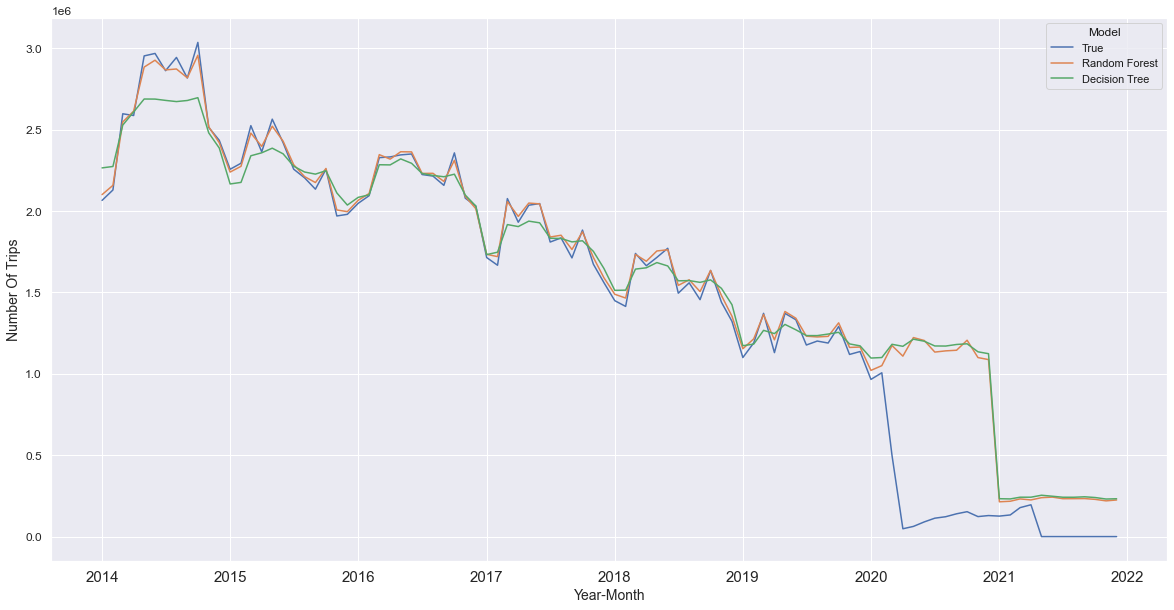

In [180]:
# Seperating and taking aggregates for random forect and decision tree along with actual values 
df_t = result.groupby(['year','month'], as_index=False)['trip_count'].sum()
df_t.columns=['Year','Month','Number Of Trips']
df_t['Model'] = 'True'
df_rf = result.groupby(['year','month'], as_index=False)['predicted_pickups_rf'].sum()
df_rf.columns=['Year','Month','Number Of Trips']
df_rf['Model'] = 'Random Forest'
df_dt = result.groupby(['year','month'], as_index=False)['predicted_pickups_dt'].sum()
df_dt.columns=['Year','Month','Number Of Trips']
df_dt['Model'] = 'Decision Tree'

# Merge datasets
month_plot = pd.concat([df_t, df_rf,df_dt], axis=0)

# COnverting year and months to strings and assing date as first day for each record
month_plot['Year'] = month_plot['Year'].astype(str)
month_plot['Month'] = month_plot['Month'].astype(str)
month_plot['Date'] = '01'

# Concatenate day, month and year
month_plot["Year-Month"] = month_plot['Month'].str.cat(month_plot['Date'],sep="-")
month_plot["Year-Month"] = month_plot['Year-Month'].str.cat(month_plot['Year'],sep="-")

# Convert to datatime from string
month_plot['Year-Month']= pd.to_datetime(month_plot['Year-Month'])

#Plotting number of trips for each model along with true values
ax = plt.figure(figsize=(20,10))
ax = sns.lineplot(x='Year-Month',y='Number Of Trips',hue='Model',data=month_plot)

plt.xticks(size=15)
plt.show()

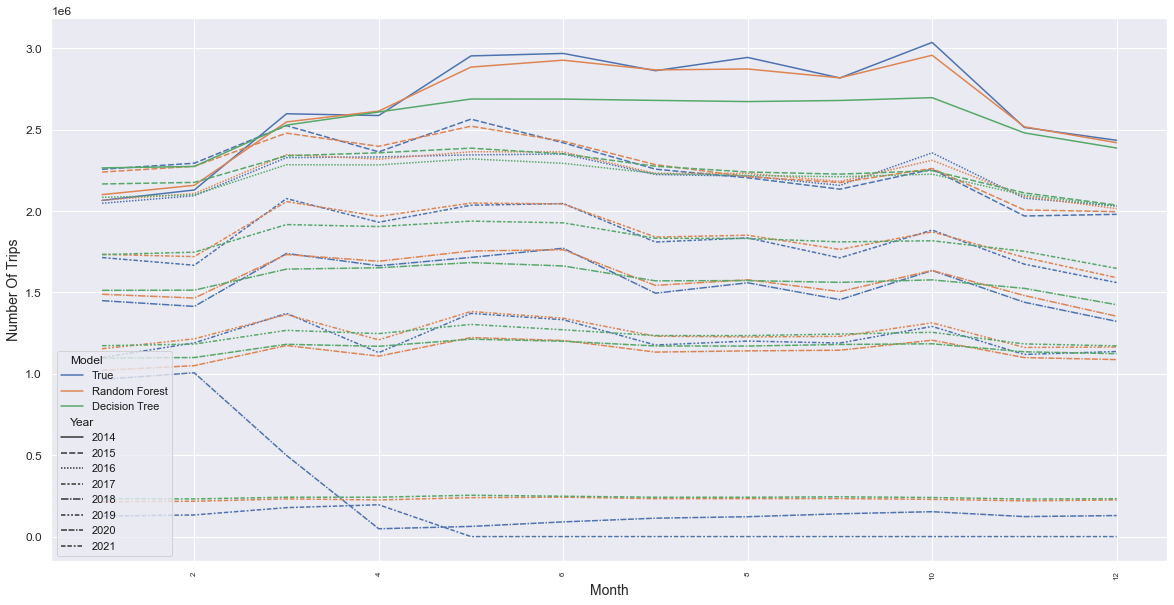

In [181]:
# Plotting for each month
df_t = result.groupby(['year','month'], as_index=False)['trip_count'].sum()
df_t.columns=['Year','Month','Number Of Trips']
df_t['Model'] = 'True'
df_rf = result.groupby(['year','month'], as_index=False)['predicted_pickups_rf'].sum()
df_rf.columns=['Year','Month','Number Of Trips']
df_rf['Model'] = 'Random Forest'
df_dt = result.groupby(['year','month'], as_index=False)['predicted_pickups_dt'].sum()
df_dt.columns=['Year','Month','Number Of Trips']
df_dt['Model'] = 'Decision Tree'

month_plot = pd.concat([df_t, df_rf,df_dt], axis=0)

ax = plt.figure(figsize=(20,10))

ax = sns.lineplot(x='Month',y='Number Of Trips',hue='Model',style='Year',data=month_plot)

plt.xticks(rotation=90,size=8)
plt.show()

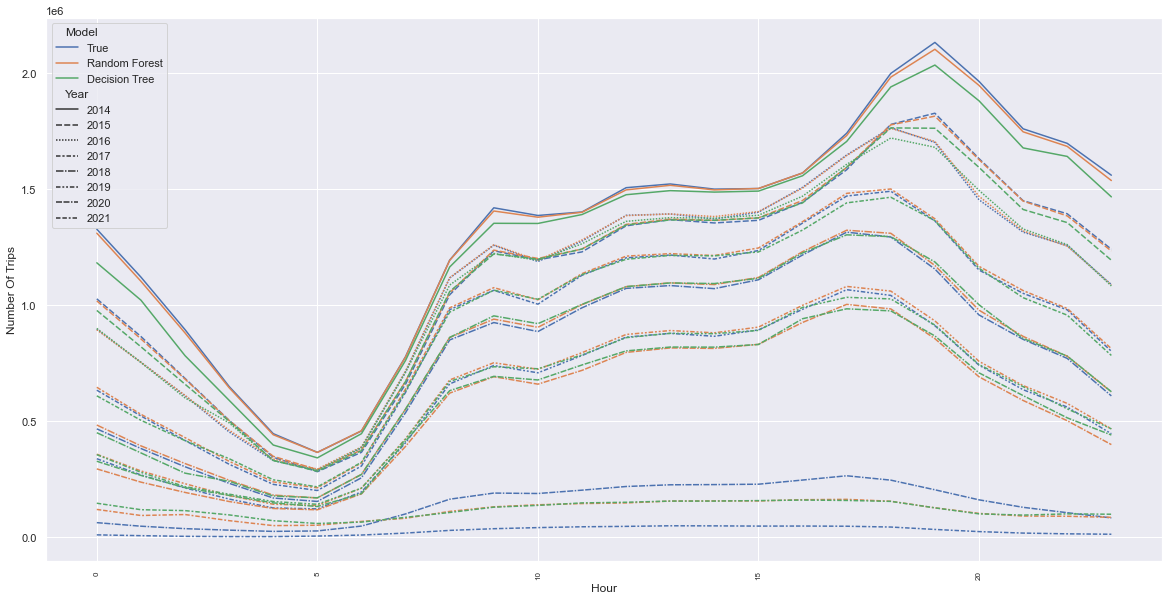

In [182]:
# Plotting for each hour of the dat
df_t = result.groupby(['year','hour'], as_index=False)['trip_count'].sum()
df_t.columns=['Year','Hour','Number Of Trips']
df_t['Model'] = 'True'
df_rf = result.groupby(['year','hour'], as_index=False)['predicted_pickups_rf'].sum()
df_rf.columns=['Year','Hour','Number Of Trips']
df_rf['Model'] = 'Random Forest'
df_dt = result.groupby(['year','hour'], as_index=False)['predicted_pickups_dt'].sum()
df_dt.columns=['Year','Hour','Number Of Trips']
df_dt['Model'] = 'Decision Tree'

sns.set(rc={ 'figure.facecolor':'white'})


hour_plot = pd.concat([df_t, df_rf,df_dt], axis=0)

ax = plt.figure(figsize=(20,10))

ax = sns.lineplot(x='Hour',y='Number Of Trips',hue='Model',style='Year',data=hour_plot)



plt.xticks(rotation=90,size=8)
plt.show()

Seprating the result dataset and plotting the density for random forest predicted and actual trip counts for the year 2020
using chicago map shape file

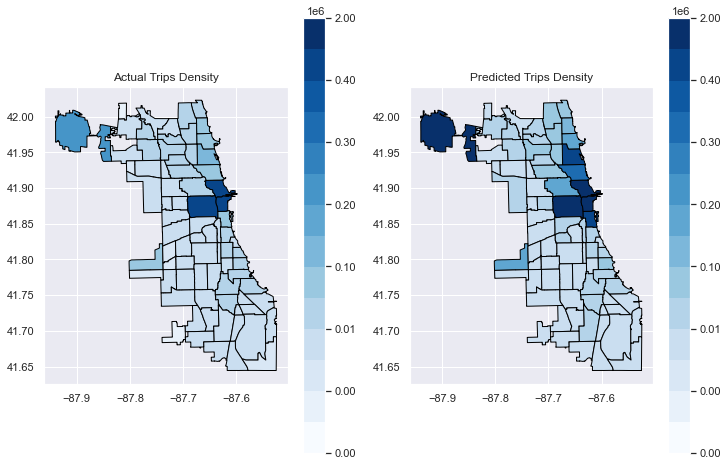

In [183]:
result_2020 = result.loc[result['year'] == 2020]
df_t = result_2020.groupby(['pickup_community_area'], as_index=False)['trip_count'].sum()
df_t.columns=['area_num_1','Number Of Trips']
df_t['Model'] = 'True'
df_rf = result_2020.groupby(['pickup_community_area'], as_index=False)['predicted_pickups_rf'].sum()
df_rf.columns=['area_num_1','Number Of Trips']
df_rf['Model'] = 'Random Forest'
df_dt = result_2020.groupby(['pickup_community_area'], as_index=False)['predicted_pickups_dt'].sum()
df_dt.columns=['area_num_1','Number Of Trips']
df_dt['Model'] = 'Decision Tree'

area_plot = pd.concat([df_t, df_rf,df_dt], axis=0)

chicago_map['area_num_1'] = chicago_map['area_num_1'].astype(int)

area_plot = chicago_map.merge(area_plot, on="area_num_1", how = 'inner')

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

cmap = mpl.cm.Blues
bounds = [0, 100, 500, 1000, 10000, 50000, 100000, 150000,200000,250000,300000,350000,400000,1000000,2000000]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

area_plot_true = area_plot.loc[area_plot['Model'] == 'True']

area_plot_pred = area_plot.loc[area_plot['Model'] == 'Random Forest']

ax1 = area_plot_true.plot(column="Number Of Trips",legend=True,
                        edgecolor='black',ax=ax1, cmap=cmap,norm=norm
                      )

ax1.set_title('Actual Trips Density')
ax2 = area_plot_pred.plot(column="Number Of Trips",legend=True,
                        edgecolor='black',ax=ax2, cmap=cmap,norm=norm
                      )
ax2.set_title('Predicted Trips Density')

plt.show()

Query to get the number of pickups for each day from the Mar-2020 staring days of COVID

In [184]:
trips_2021 = """ 
            SELECT DATE(trip_start_timestamp) trip_date,
                   count(*) as trip_count
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
           WHERE extract(date from trip_start_timestamp) between PARSE_DATE('%m/%d/%Y', '03/20/2020') AND PARSE_DATE('%m/%d/%Y', '04/30/2021')
             AND pickup_latitude is not null and pickup_longitude is not null
             AND trip_end_timestamp is not null
             AND trip_end_timestamp >= trip_start_timestamp
             AND TIMESTAMP_DIFF(trip_end_timestamp, trip_start_timestamp, MINUTE) < 180
             AND pickup_community_area is not null AND pickup_community_area > 0
             AND dropoff_community_area is not null AND dropoff_community_area > 0
             AND trip_total >= 3.25
             AND trip_miles <= 100
            GROUP BY DATE(trip_start_timestamp)
        """

trips_2021_job = client.query(trips_2021)

trips_2021_result = trips_2021_job.to_dataframe()

trips_2021_result['trip_date']= pd.to_datetime(trips_2021_result['trip_date'])
trips_2021_result = trips_2021_result.set_index('trip_date')

Plotting number of trips for each day from the start of COVID to see if there is improvement in 2021

<AxesSubplot:xlabel='trip_date'>

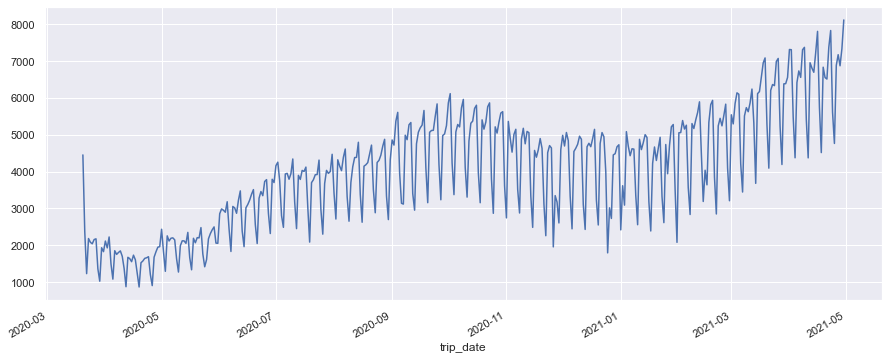

In [185]:
fig, ax = plt.subplots(nrows=1, ncols=1)

trips_2021_result.plot(figsize=(15, 6),ax=ax,legend=False)